# Load Data

Author:  P. Lewis

Date:    Thu 25 Feb 2016

This section demonstrates the preparation of datasets for BRDF/albedo processing.

An example is used where we have *broadband* observation datasets from MERIS, SPOT VGT `['bbdr.meris', 'bbdr.vgt']` and MODIS (Terra and Aqua) `['mod09', 'myd09']`.

For testing other constraints, we also have different versions of a climatology (the 'prior') `['prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow']`.

We also develop the arrays for differential constraints.

For comparison, we also have the results from the GlobAlbedo processing chain `['ga.brdf.nosnow', 'ga.brdf.snow', 'ga.brdf.merge']`. [NOT YET DONE]

In [1]:
# load required libraries: you may need to install netCDF4
from defaults import *
%matplotlib inline

data directory /Users/plewis/QA4ECV_ATBD/data


In [2]:
datakeys = np.array(['bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow'])
# load the datasets into a dictionary in ncdata
ncdata = {}
for k in datakeys:
    print k,
    ncdata[k] = load_obj('obj/'+ k + '_s2.0_' )

bbdr.meris bbdr.vgt ga.brdf.merge ga.brdf.nosnow ga.brdf.snow mod09 myd09 prior.v2.nosnow prior.v2.snow prior.v2.snownosnow


We next consider what time period we want to do mapping for.

Here, we start from the first date in the `bbdr.vgt` dataset and end on the last date of `mod09`.


In [3]:
d0,d1 = ncdata['bbdr.vgt']['date'][0],ncdata['mod09']['date'][-1]
print 'from',d0,'to',d1,'inclusive',
ndays = (d1-d0).days + 1
print 'which gives',ndays,'days'

from 1998-04-03 to 2016-01-01 inclusive which gives 6483 days


Define the wavebands of the dataset:

In [4]:
bands = np.array(['VIS','NIR','SW'])
nbands = bands.shape[0]

Now we pull out the parts of the dataset that we want access to, and structure them in convenient forms.

For `meris` and `vgt`, this is:

    reflectance:
        BB
        
    BRDF kernels:
        Isotropic 
        Kvol_BRDF
        Kgeo_BRDF
        
    Covariance matrix terms:
        sig_BB
        
All of these terms are spectral (i.e. defined for each waveband) (so, `BB_VIS` etc., `Kvol_BRDF_VIS` etc., `sig_BB_VIS_NIR` etc.).

Note that Isotropic is all ones (for valid samples), so this is provided during this reading, rather than loading it.

## preparing the observation matrices

Define inverse covariance (weighting) matrices $W_o$, of shape `(nbands,nbands)` associated with observational constraints, that are full matrices. Define the vector of observations $y$ of shape `(nbands,1)`, and a matrix $K$ of shape `(nbands * nk,nbands)`, where `nbands` is the number of wavebands (3 here) and `nk` the number of kernels (3 here). The state vector $x$ has shape `(nbands * nk,1)`

The form of $K$ is:

$$
    K = \left( \begin{array}{ccc}
k_0(\lambda_0) & k_1(\lambda_0) & k_2(\lambda_0) & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & k_0(\lambda_1) & k_1(\lambda_1) & k_2(\lambda_1) & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & k_0(\lambda_2) & k_1(\lambda_2) & k_2(\lambda_2) \end{array} \right)
$$

for kernels $k_i(\lambda_j)$ for waveband $\lambda_j$, with $k_0, k_1, k_2$ representing the `Isotropic`, `Kvol` and `Kgeo` kernels respectively.

Let:

$$
    J_o = \frac{1}{2}  (y - K x)^T W_o (y - K x)
$$

Differentiation wrt $x$:

$$
    J'_o =  -  K^T W_o (y - K x) 
$$

and again:

$$
    J''_o =  -  K^T W_o K 
$$


setting the sum of derivatives to zero (and weighted summing of this over many cases):

$$
    J' = 0 = - K^T W_o (y - K x) 
$$

so

$$
     \left(  K^T W_o K  \right) x =  \left(  K^T W_o y \right)
$$

Applying these equations to the data for each sample individually (there is no observational covariance assumed between data samples), we note that the key representational forms are:

$$
A_o = K^T W_o K
$$

of shape `(nbands * nk,nbands * nk)` and

$$
b_o = K^T W_o y
$$

of shape `(nbands * nk,1)` (i.e. the same shape as `x`).

So, in this next section, we calculate these two key matrices and store them in `s3.0` and `Ab` files.

The `Ab` files contain these key matrices `A_o` and `b_o` accumulated into the fmatrix for the complete time period.

myd09 masked
mod09 masked
bbdr.meris masked
bbdr.vgt masked
bbdr.meris bbdr.vgt mod09 myd09


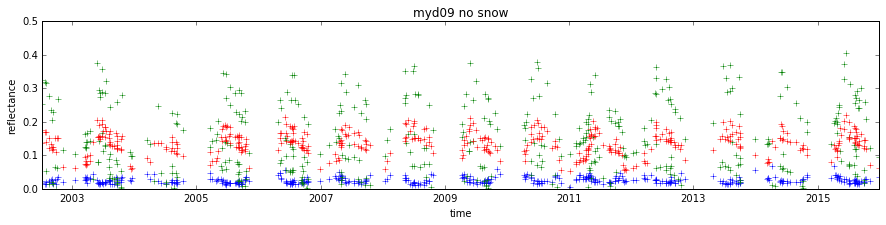

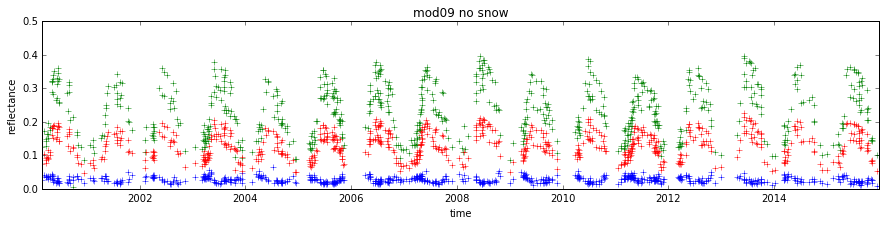

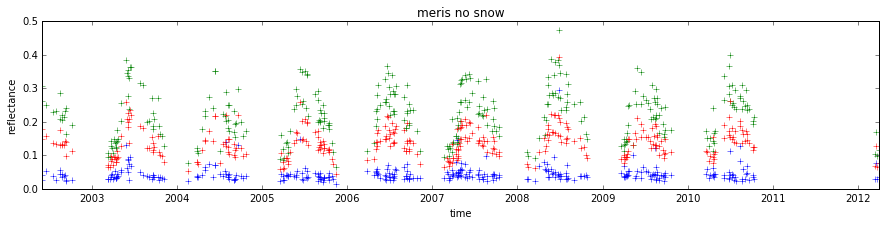

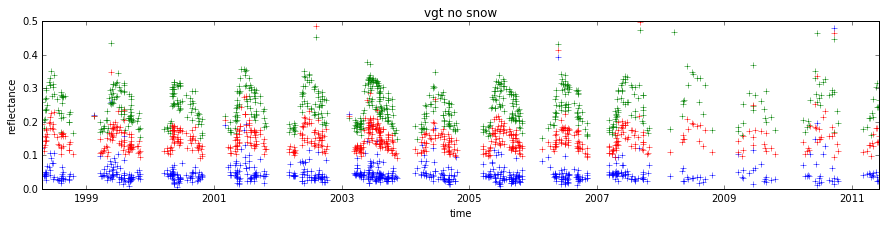

In [5]:
# pixel row col in dataset
r,c = 0,0

ncdata2 = {}

for m in ['myd09', 'mod09', 'meris','vgt']:
    plt.figure(figsize=(15,3))
    datatype = None
    # ID the datazet
    try:
        mm = 'bbdr.%s'%m
        dataset = ncdata[mm]
        ncdata2[mm] = dataset2 = {}
        # these are 3D datasets
        sl = (slice(None),r,c)
        sVis = '_BRDF_VIS'
        sNir = '_BRDF_NIR'
        sSw  = '_BRDF_SW'
        datatype = 'A'
        
    except:
        # these may be 1 D but need to fix
        mm = m
        dataset = ncdata[mm]
        ncdata2[mm] = dataset2 = {}
        sl = slice(None)
        sVis = sNir = sSw = ''
        datatype = 'B'
    if not datatype:
        break
    print mm,
    # pull reflectance data
    refl = np.array([np.array(dataset['BB_VIS'])[sl],
                     np.array(dataset['BB_NIR'])[sl],
                     np.array(dataset['BB_SW'])[sl]])
    # identify dodgy values from refl
    # these data are shaped (nbands, nsamples)
    # If any of the nbands is False, we want to ignore all bands
    # so 
    mask = ((refl>0)*(refl<1)*np.isfinite(refl)).prod(axis=0).astype(bool)
    try:
        # assuming dataset['mask'] is True for good data
        #import pdb;pdb.set_trace()
        mask = np.logical_and(np.array(dataset['mask'])[sl],mask)
        print 'masked'
    except:
        try:
            mask = np.logical_and(~np.array(dataset['snow_mask'])[sl],mask)
            print 'masked'
        except:
            pass
    # easiest to reload now ...
    refl = np.array([np.array(dataset['BB_VIS'])[sl][mask],
                     np.array(dataset['BB_NIR'])[sl][mask],
                     np.array(dataset['BB_SW'])[sl][mask]])

    # isotropic
    Isotropic = np.ones_like(dataset['Kvol%s'%sVis])
    # kernels
    kernels = np.array([[Isotropic[sl][mask],\
                         Isotropic[sl][mask],\
                         Isotropic[sl][mask]],\
                        [np.array(dataset['Kvol%s'%sVis])[sl][mask],\
                         np.array(dataset['Kvol%s'%sNir])[sl][mask],\
                         np.array(dataset['Kvol%s'%sSw])[sl][mask]],\
                        [np.array(dataset['Kgeo%s'%sVis])[sl][mask],\
                         np.array(dataset['Kgeo%s'%sNir])[sl][mask],\
                         np.array(dataset['Kgeo%s'%sSw])[sl][mask]]\
                       ])
    
    # uncertainty
    if datatype == 'A':
        var     = np.array([[np.array(dataset['sig_BB_VIS_VIS'])[sl][mask],\
                         np.array(dataset['sig_BB_VIS_NIR'])[sl][mask],\
                         np.array(dataset['sig_BB_VIS_SW'])[sl][mask]],\
                        [np.array(dataset['sig_BB_VIS_NIR'])[sl][mask],\
                         np.array(dataset['sig_BB_NIR_NIR'])[sl][mask],\
                         np.array(dataset['sig_BB_NIR_SW'])[sl][mask]],\
                        [np.array(dataset['sig_BB_VIS_SW'])[sl][mask],\
                         np.array(dataset['sig_BB_NIR_SW'])[sl][mask],\
                         np.array(dataset['sig_BB_SW_SW'])[sl][mask]]\
                       ])    

        weight = np.zeros_like(var)
        for i in xrange(refl.shape[-1]):
            try:
                weight[...,i] = np.matrix(var[...,i]).I
            except:
                pass
        del var
    elif datatype == 'B':
        w1 = [[dataset['weight_BB_VIS_VIS']]*len(mask),\
                            [dataset['weight_BB_NIR_VIS']]*len(mask),\
                            [dataset['weight_BB_SW_VIS']]*len(mask)]
        w2 = [[dataset['weight_BB_NIR_VIS']]*len(mask),\
                            [dataset['weight_BB_NIR_NIR']]*len(mask),\
                            [dataset['weight_BB_SW_NIR']]*len(mask)]
        w3 = [[dataset['weight_BB_SW_VIS']]*len(mask),\
                            [dataset['weight_BB_SW_NIR']]*len(mask),\
                            [dataset['weight_BB_SW_SW']]*len(mask)]
        weight = np.array([w1,w2,w3])  
        weight = weight[...,mask]

    dates = dataset['date'][mask]        
    
    # store in dataset2
    dataset2['refl'] = refl.copy()
    dataset2['kernels'] = kernels.copy()
    dataset2['weight'] = weight.copy()
    dataset2['date'] = dates.copy()
    dataset2['year'] = np.array(dataset['yeardoy'])[:,0]
    dataset2['doy'] = np.array(dataset['yeardoy'])[:,1]
    dataset2['idoy'] = np.array([k.days for k in (dates - d0)])
    
    
    # form A and b matrices
    nk = dataset2['kernels'].shape[0]
    bigshape = tuple(np.array([ndays,ndays]) * nk * nbands)
    AD = scipy.sparse.lil_matrix(bigshape)
    bD = scipy.sparse.lil_matrix((bigshape[0],1))
    steps = nbands * nk
    nsamp = dataset2['kernels'].shape[-1]
    
    # load into A and b matrices
    # loop over samples
    for i in xrange(nsamp):
        # the information for this sample
        thisR = np.matrix(refl[...,i]).T
        thisK = np.matrix(kernels[...,i]).T
        thisW = np.matrix(weight[...,i])
        thisdoy = dataset2['idoy'][i]
        k=np.matrix(np.zeros((nbands,nbands*nk)))
        # load k
        for j in xrange(nbands): k[j,j*nk:(j+1)*nk] = thisK[j]
        thisKR = k.T*thisW*thisR
        thisKK = k.T*thisW*k
        sli = slice(thisdoy*steps,(thisdoy+1)*steps)
        
        # add ie accumulate in case of multiple samples per day
        AD[sli,sli] += thisKK
        bD[sli,0] += thisKR
    Ab = {'A':AD,'b':bD,'doys':np.arange(ndays),'d0':d0}
    save_obj(Ab,'obj/' + mm+'_Ab_')

    for i in xrange(nbands):
        plt.plot(dates,refl[i],'+')
    plt.ylim(0,.5)
    plt.xlabel('time')
    plt.ylabel('reflectance')
    #plt.legend(loc='best')
    plt.title('%s no snow'%m)
    
# save as s3.0
for k in datakeys:
    try:
        save_obj(ncdata2[k],'obj/' + k+'_s3.0_')
        print k,
    except:
        pass

## prepare derivative

Here, we form and store the derivative matrix we need for naive implementation.

In [6]:
# form a D matrix -- should replace by sparse
I = np.eye(ndays)
D = np.matrix(I - np.roll(I,-1))
D1 = D * D.T

# form a D matrix -- should replace by sparse
D = np.matrix(I - np.roll(I,-365))
D1365 = D * D.T

In [7]:
D1 = scipy.sparse.lil_matrix(D1)
D1365 = scipy.sparse.lil_matrix(D1365)
print D1.todense()
print D1365.todense()

[[ 1. -1.  0. ...,  0.  0.  0.]
 [-1.  2. -1. ...,  0.  0.  0.]
 [ 0. -1.  2. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  2. -1.  0.]
 [ 0.  0.  0. ..., -1.  2. -1.]
 [ 0.  0.  0. ...,  0. -1.  1.]]
[[ 2.  0.  0. ...,  0.  0.  0.]
 [ 0.  2.  0. ...,  0.  0.  0.]
 [ 0.  0.  2. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  2.  0.  0.]
 [ 0.  0.  0. ...,  0.  2.  0.]
 [ 0.  0.  0. ...,  0.  0.  3.]]


In [8]:
nk = dataset2['kernels'].shape[0]
bigshape = tuple(np.array(D1.shape) * nk * nbands)
print bigshape
AD = scipy.sparse.lil_matrix(bigshape)
bD = scipy.sparse.lil_matrix((bigshape[0],1))

# make a big A matrix
AD365 = scipy.sparse.lil_matrix(bigshape)
bD365 = scipy.sparse.lil_matrix((bigshape[0],1))
print AD.shape,bD.shape

(58347, 58347)
(58347, 58347) (58347, 1)


In [9]:
steps = nbands * nk
for i in xrange(steps):
    AD[i::steps,i::steps] = D1
    AD365[i::steps,i::steps] = D1365

In [10]:
k = 'D1'
Ab = {'A':AD,'b':bD,'doys':np.arange(ndays),'d0':d0}
save_obj(Ab,'obj/' + k+'_Ab_')
print k,
k = 'D365'
Ab = {'A':AD,'b':bD,'doys':np.arange(ndays),'d0':d0}
save_obj(Ab,'obj/' + k+'_Ab_')
print k

D1 D365


In [11]:
# show how this is arranged:

for j in xrange(20): 
    for i in xrange(20): 
        print AD[j,i],
    print
    
# so, it is made up of 9 x 9 blocks

1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0
-1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0
0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0
0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 -1.0 0.0 0.0 0

## preparing the prior matrices


Let:

$$
    J_p = \frac{1}{2} w_p (x_p - x)^T W_p (x_p - x)
$$

Differentiation wrt $x$:

$$
    J'_p = - w_p W_p (x_p - x)
$$

and


$$
    J''_p = w_p W_p
$$

The prior data are only sampled every 8 days.

$x_p$ is the prior mean which can be given the shape $(n_{bands},46,n_{kernels})$

The weighting matrix $W_o$ is $(n_{bands} \times n_{kernels} \times n_{days},n_{bands} \times n_{kernels}\times n_{days})$ but is sparse, and diagonal.



In [12]:
pps = ['prior.v2.snow' ,'prior.v2.nosnow']

for pp in pps:

    prior = ncdata[pp]

    # mean
    mean = []
    for b in bands:
        m = np.array(prior['Mean_%s'%b]).squeeze().reshape(nk,46)
        mean.append(m)
    mean = np.array(mean)
    print mean.shape

    # var -> weight
    kk = ['f%d'%i for i in xrange(nk)]
    var = [[]]*nbands
    for band in xrange(nbands):
        var[band] = []
        for p,f0 in enumerate(kk):
            cc = np.array(prior['Cov_%s_%s_%s_%s'%(bands[band],f0,bands[band],f0)]).squeeze()
            var[band].append(cc)  
    var = np.array(var)
    weight = 1./var
    weight = weight/scale
    print weight.shape
    # these are formed 
    xp = np.zeros((nbands*nk*ndays))
    Wp = np.zeros((nbands*nk*ndays))
    
    for d in xrange(ndays):
        thisd = d0 + timedelta(d)
        thisdoy = ((thisd - date(thisd.year,1,1)).days)/8
        for k in xrange(nk): 
            xp[d*nbands*nk+k*nbands:d*nbands*nk+(k+1)*nbands] = mean[:,k,thisdoy]
            Wp[d*nbands*nk+k*nbands:d*nbands*nk+(k+1)*nbands] = weight[:,k,thisdoy]
    Ap = scipy.sparse.lil_matrix(scipy.sparse.diags(Wp,0))
    bp = Ap * scipy.sparse.lil_matrix(xp).T
    Ab = {'A':Ap,'b':bp,'doys':np.arange(ndays),'d0':d0}
    save_obj(Ab,'obj/' + pp + '_Ab_')

(3, 3, 46)
(3, 3, 46)
(3, 3, 46)
(3, 3, 46)


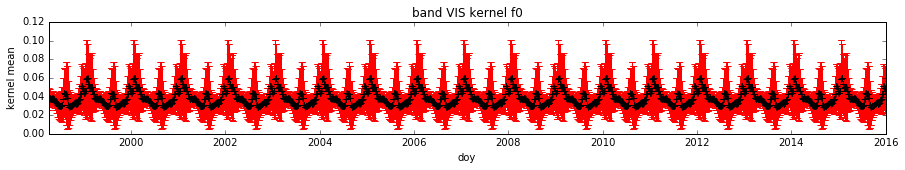

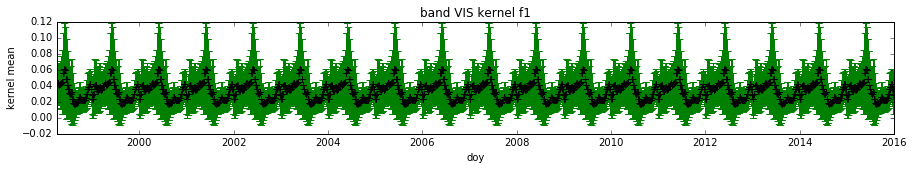

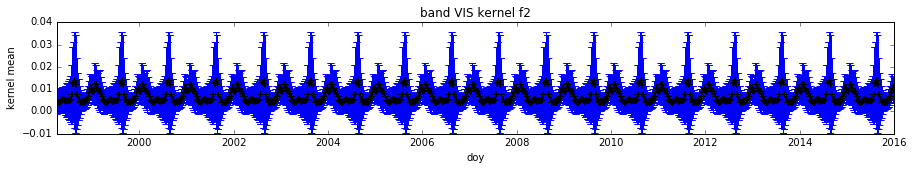

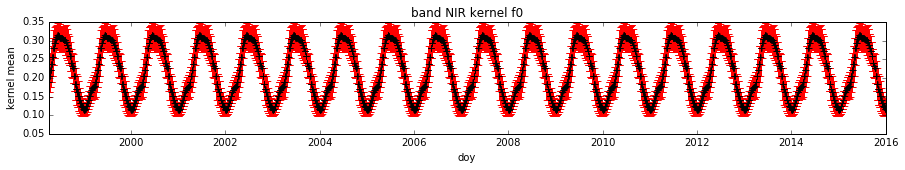

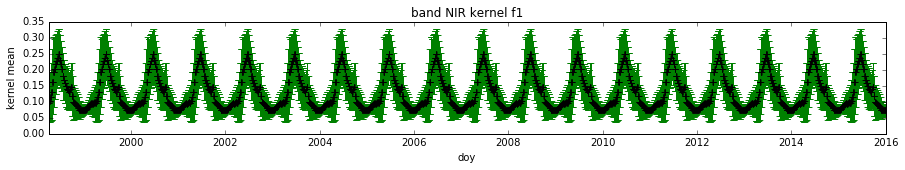

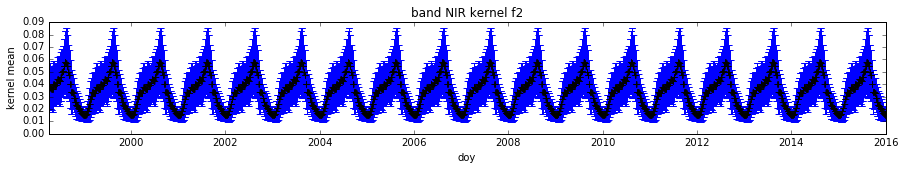

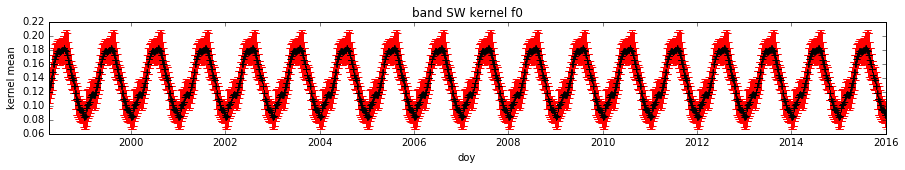

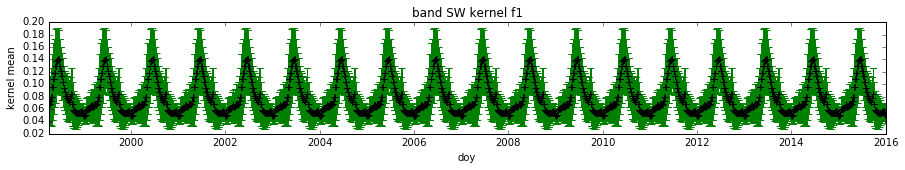

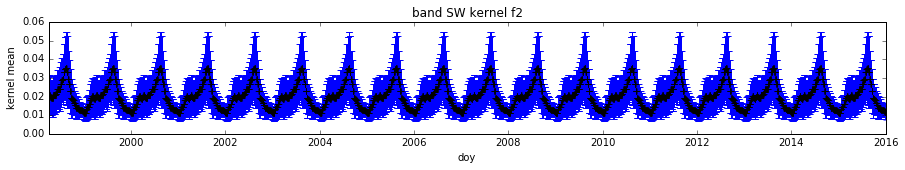

In [13]:
# visualise the mean and sd
colour = ['r','g','b']

for band in xrange(nbands):
    for k in xrange(nk):
        xx = xp[k*nbands+band::nbands*nk]
        wx = Wp[k*nbands+band::nbands*nk]

        # make an x array for plotting
        x = np.array([np.array([[timedelta(i)+d0 \
                    for i in np.arange(ndays)]]).T]).T.squeeze()

        # yerr for this band for the 3 kernels
        yerr = np.sqrt(1./wx)/np.sqrt(scale)

        plt.figure(figsize=(15,2))
        plt.errorbar(x, xx, c='%s'%colour[k], yerr=yerr)
        plt.plot(x,xx,'k+',label=kk[k])
        plt.title('band %s kernel %s'%(bands[band],kk[k]))
        plt.xlabel('doy')
        plt.ylabel('kernel mean')
